In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import cv2
import os
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torchvision import transforms
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

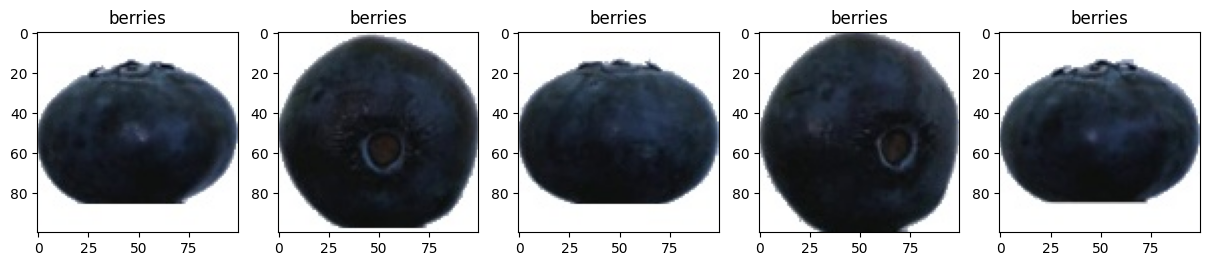

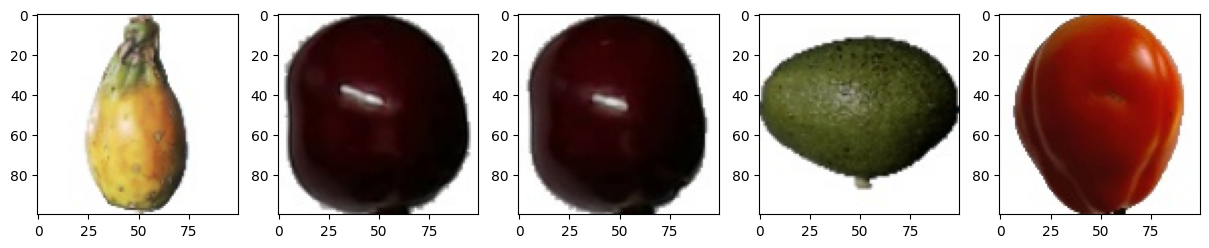

In [2]:
def process_files_with_labels(train_folder, labels_file=None):
    labels_df = pd.read_csv(labels_file)
    images = []
    labels = []
    for index, row in labels_df.iterrows():
        file_name = row['filename']
        label = row['label']
        file_path = os.path.join(train_folder, file_name)
        image = cv2.imread(file_path) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        resized_image = cv2.resize(image, (100, 100)) 
        images.append(resized_image)
        labels.append(label)
    return images, labels

def process_files_test(test_folder):
    images = []
    for dirpath, dirnames, filenames in os.walk(test_folder):
        for file in filenames:
            file_path = os.path.join(dirpath, file)
            image = cv2.imread(file_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            resized_image = cv2.resize(image, (100, 100)) 
            images.append(resized_image)
    return images

def display_images(image_list, labels_list=None):
    rows, col = 1, 5
    fig = plt.figure(figsize=(15, 7))
    for index in range(min(len(image_list), 5)):
        ax = fig.add_subplot(rows, col, index + 1)
        image = image_list[index]
        image_pil = Image.fromarray(image)  
        ax.imshow(image_pil)  
        if labels_list is not None and index < len(labels_list):
            ax.set_title(str(labels_list[index])) 
        ax.axis('on')
    plt.show()

PATH = "C:\\work\\PyTorch v2\\"
TRAIN_PATH = PATH + "train\\"
TEST_PATH = PATH + "test\\"
CSV_PATH = PATH + "train_labels.csv"


train_images, train_labels = process_files_with_labels(TRAIN_PATH, CSV_PATH)
test_images = process_files_test(TEST_PATH)



display_images(train_images, train_labels)
display_images(test_images)

label2id = {"berries": 0, "fruits": 1, "vegetables": 2}
id2label = {0: "berries", 1: "fruits", 2: "vegetables"}


In [3]:
train_pixels = np.array(train_images)
test_pixels = np.array(test_images)
train_images = np.array([x.reshape(100,100,3) for x in train_pixels])
test_images = np.array([y.reshape(100,100,3) for y in test_pixels])

In [4]:
train_images, test_images, train_labels, test_labels = train_test_split(train_images, train_labels, test_size=0.3, stratify = train_labels, random_state=101)
print('Распределение данных в тренировочной выборке')
print(pd.Series(train_labels).value_counts())

print("")
print('Распределение данных в тестовой выборке')
print(pd.Series(test_labels).value_counts())
train_images = train_images[:5700]
train_labels = train_labels[:5700]
test_images = test_images[:2400]
test_labels = test_labels[:2400]


Распределение данных в тренировочной выборке
berries       1921
fruits        1920
vegetables    1920
Name: count, dtype: int64

Распределение данных в тестовой выборке
fruits        824
berries       823
vegetables    823
Name: count, dtype: int64


In [5]:
class CreateDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels 
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = label2id[self.labels[idx]]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label 

In [13]:
t = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = CreateDataset(train_images, train_labels, transform=t)
train_loader = DataLoader(train_dataset, shuffle=True , batch_size=100) 

test_dataset = CreateDataset(test_images, test_labels, transform=t)
test_loader = DataLoader(test_dataset, shuffle=True , batch_size=100)

In [14]:
class Net(nn.Module):
    def __init__(self, classes=3):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3) 
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
        
        self.pool = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(33856, 100)
        self.fc2 = nn.Linear(100, classes)
        
    def forward(self, x):
        x = self.relu(self.pool(self.conv1(x)))
        x = self.relu(self.pool(self.conv2(x)))
        
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)
                

In [15]:
EPOCHS = 10
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.001)        

In [16]:
for epoch in range(EPOCHS):
    net.train()
    for data in train_loader:
        
        X_train, y_train = data
        
        y_pred = net(X_train)
        
        optimizer.zero_grad()

        train_loss = criterion(y_pred, y_train)
        train_loss.backward()
        optimizer.step()
    print(f"Epoch :{epoch+1}, Train Loss = {train_loss.item()}")

Epoch :1, Train Loss = 0.018325190991163254
Epoch :2, Train Loss = 0.005899655167013407
Epoch :3, Train Loss = 0.0007482401560992002
Epoch :4, Train Loss = 0.0005185511545278132
Epoch :5, Train Loss = 0.0003008182975463569
Epoch :6, Train Loss = 0.00016290605708491057
Epoch :7, Train Loss = 0.00016828926163725555
Epoch :8, Train Loss = 0.00015386879385914654
Epoch :9, Train Loss = 6.989269604673609e-05
Epoch :10, Train Loss = 3.235954500269145e-05


In [17]:
correct, total = 0, 0

pred_probabs = []
pred_y = []
test_y = []
test_x = []
net.eval()

for data in test_loader:
    X_test, y_test = data
    output = net(X_test)
    _, predicted = torch.max(output.data,1)
    total += y_test.size(0)
    correct += (predicted == y_test).sum().item()
    
    pred_probabs.append(output)
    test_x.append(X_test)
    pred_y.append(predicted)
    test_y.append(y_test)
test_accuracy = 100 * correct / total
print('Test Accuracy : ', test_accuracy)

Test Accuracy :  100.0


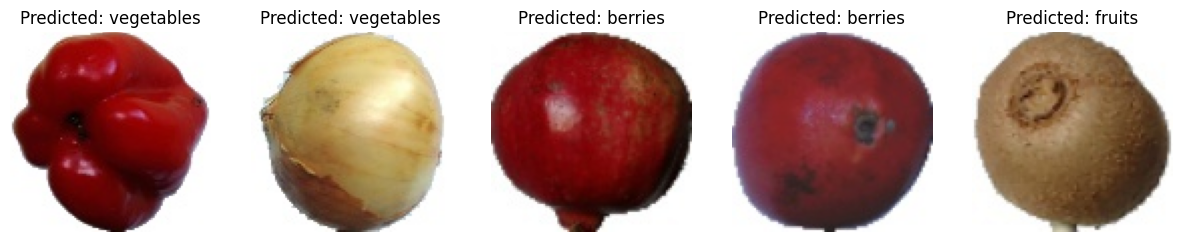

In [25]:
net.load_state_dict(torch.load('trained_model.pth'))
net.eval()

def display_predictions(images, predictions):
    rows, col = 1, 5
    fig = plt.figure(figsize=(15, 7))
    for index in range(min(len(images), 5)):
        ax = fig.add_subplot(rows, col, index + 1)
        image = images[index]
        image_np = image.numpy().transpose((1, 2, 0))
        image_np = (image_np * np.array([0.3081])) + np.array([0.1307]) 
        image_np = np.clip(image_np, 0, 1)
        ax.imshow(image_np)
        predicted_label = id2label[predictions[index]]  
        ax.set_title(f'Predicted: {predicted_label}')
        ax.axis('off')
    plt.show()

pred_y = []
test_x = []

for data in test_loader:
    X_test, _ = data
    output = net(X_test)
    _, predicted = torch.max(output.data, 1)
    pred_y.extend(predicted.tolist())  
    test_x.extend(X_test)

display_predictions(test_x, pred_y)

In [1]:
print("Pandas — это библиотека Python, предназначенная для эффективной работы с табличными данными. Numpy — это фундаментальная библиотека для научных вычислений в Python. Matplotlib — это библиотека для создания статических, анимированных и интерактивных визуализаций в Python. PyTorch — это библиотека машинного обучения для Python, которая предоставляет гибкие инструменты для создания и обучения нейронных сетей. ")

Pandas — это библиотека Python, предназначенная для эффективной работы с табличными данными. Numpy — это фундаментальная библиотека для научных вычислений в Python. Matplotlib — это библиотека для создания статических, анимированных и интерактивных визуализаций в Python. PyTorch — это библиотека машинного обучения для Python, которая предоставляет гибкие инструменты для создания и обучения нейронных сетей. 
